**Data Source:** https://fred.stlouisfed.org/series/MRTSSM448USN

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [3]:
df.columns=['Production']

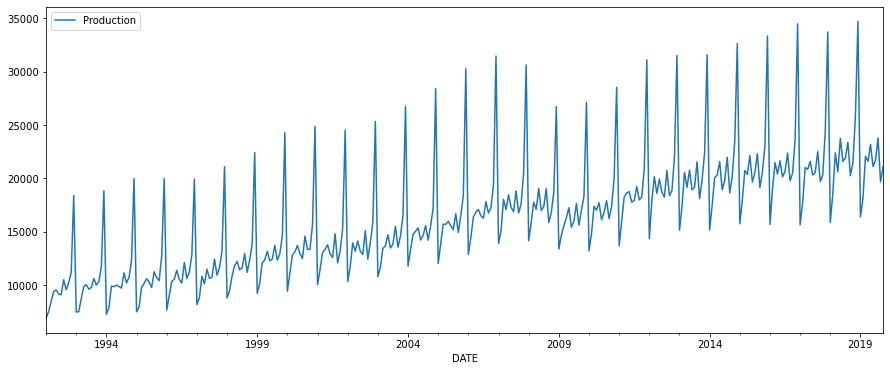

In [4]:
rcParams['figure.figsize']=15,6
df.plot()

### Train test split

Taking last 18 months for testing

In [5]:
train=df[:-18]
test=df[-18:]

In [6]:
train

,Production
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [7]:
test

,Production
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scaling of the train and test data

In [8]:
scaler=StandardScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

### Time Series Generation

Taking previous 12 records for prediction of the next record

In [9]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [10]:
X,y = generator[0]

In [11]:
X

array([[[-1.72618002],
        [-1.61435199],
        [-1.43286999],
        [-1.2561588 ],
        [-1.22619805],
        [-1.29795119],
        [-1.31302698],
        [-1.04395271],
        [-1.22333556],
        [-1.09337841],
        [-0.9153314 ],
        [ 0.46019152]]])

In [12]:
n_features=1

In [13]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [16]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [17]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
304/304 [==============================] - 3s 9ms/step - loss: 0.5218 - val_loss: 0.0940
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.3525 - val_loss: 0.0799
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.1790 - val_loss: 0.1233
Epoch 4/20
304/304 [==============================] - 2s 7ms/step - loss: 0.1341 - val_loss: 0.0244
Epoch 5/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0438 - val_loss: 0.0654
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0377 - val_loss: 0.0155
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0465 - val_loss: 0.0211
Epoch 8/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0348 - val_loss: 0.0093
Epoch 9/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0276 - val_loss: 0.0304
Epoch 10/20
304/304 [===

In [18]:
losses = pd.DataFrame(model.history.history,index=np.arange(1,len(model.history.history['loss'])+1))
losses.head()

,loss,val_loss
1,0.521847,0.094009
2,0.352520,0.079896
3,0.178966,0.123265
4,0.134116,0.024367
5,0.043764,0.065389


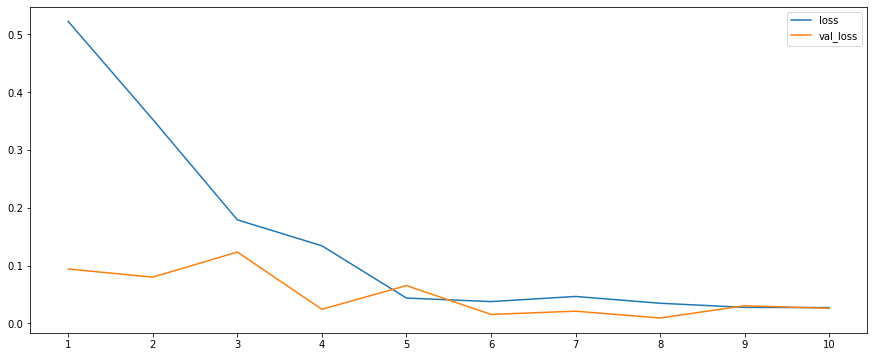

In [19]:
losses.plot()
plt.xticks(losses.index)
plt.show()

### Test Predictions

In [20]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

As the data has been scaled, they must be transformed back to original scale in order to make comparisons

In [21]:
true_predictions = scaler.inverse_transform(test_predictions)

In [22]:
test['Predictions'] = true_predictions
test.head()

,Production,Predictions
DATE,,
2018-05-01,23764,21793.720703
2018-06-01,21589,20855.046875
2018-07-01,21919,21095.132812
2018-08-01,23381,22900.472656
2018-09-01,20260,20353.136719


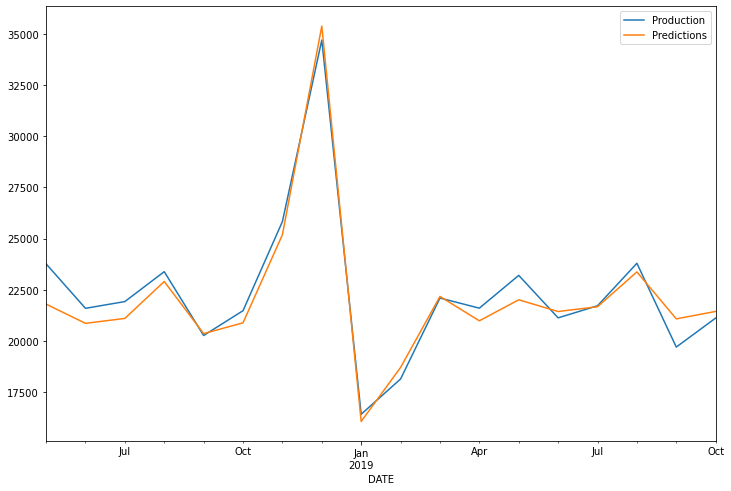

In [23]:
test.plot(figsize=(12,8))

### Evaluating the model

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test['Production'],test['Predictions'],squared=False)

785.6960680284569

In [25]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100
MAPE(test['Production'],test['Predictions'])

2.8221081881147643

### Retraining the model for future forecasting

In [33]:
scaler=StandardScaler()
df_sc=scaler.fit_transform(df)

In [34]:
length=12
TimeseriesGenerator(df_sc,df_sc,length=length,batch_size=1)

In [35]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator,epochs=8)

Epoch 1/8
304/304 [==============================] - 2s 5ms/step - loss: 0.6023
Epoch 2/8
304/304 [==============================] - 2s 7ms/step - loss: 0.4255
Epoch 3/8
304/304 [==============================] - 2s 6ms/step - loss: 0.3256
Epoch 4/8
304/304 [==============================] - 2s 6ms/step - loss: 0.1111
Epoch 5/8
304/304 [==============================] - 2s 6ms/step - loss: 0.1520
Epoch 6/8
304/304 [==============================] - 2s 6ms/step - loss: 0.3081
Epoch 7/8
304/304 [==============================] - 2s 6ms/step - loss: 0.0909
Epoch 8/8
304/304 [==============================] - 2s 7ms/step - loss: 0.0487


Forecasting for next 12 months

In [36]:
forecast = []
periods = 12
first_eval_batch = df_sc[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [37]:
forecast = scaler.inverse_transform(forecast)

In [38]:
forecast_df = pd.DataFrame(data=forecast,index=pd.date_range(start='2019-11-01',periods=periods,freq='MS'),
                           columns=['Forecast'])

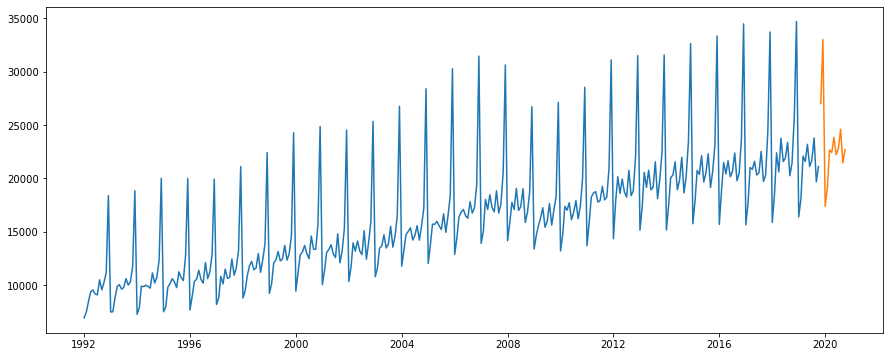

In [39]:
plt.plot(df)
plt.plot(forecast_df)